# Plot UC1 results

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from Algorithms.models_audio_mae import audioMae_vit_base

### Params

In [2]:
directory = "/home/benfenati/code/tle-supervised/Results/uc1_results/"
dim_filtering = 120
# colors = ['#A9D18E', '#9DC3E6']
colors = ['#73AD4C', '#6BA7DE']

### Utils

In [5]:
def compute_threshold_accuracy(anomalies, normal, ax, min, max, only_acc = 0, dim_filtering=dim_filtering):
    new_normal = []
    for i in np.arange(0, len(normal-dim_filtering)):
        new_normal.append(np.median(normal[i:(i+dim_filtering)]))
    new_anomalies = []
    for i in np.arange(0, len(anomalies-dim_filtering)):
        new_anomalies.append(np.median(anomalies[i:(i+dim_filtering)]))
    th_step = np.median(new_normal[:int(len(new_normal)/4)])
    #increase threshold if necessary
    th = th_step
    while sum(new_normal[:int(len(new_normal)/4)]+np.std(new_normal[:int(len(new_normal)/4)]) < th) != len(new_normal[:int(len(new_normal)/4)]):
        th += th_step/1000
    spec = sum(new_normal < th) / len(new_normal)
    sens = sum(new_anomalies > th) / len(new_anomalies)
    acc = (sum(new_normal < th) + sum(new_anomalies > th)) / (len(new_normal) + len(new_anomalies))
    # print(f"Sensitivity: {sens} Spcificity: {spec} Accuracy: {acc}")
    if only_acc == 0:
        ax.axhline(y=(th-min)/(max-min), color='r', linestyle='--', label = "Threshold")
    return spec, sens, acc

def plot_results_PCA(data, data2, fig):
    th = np.median(data) + 1 * np.std(data)
    data_new = data[data<th]
    th = np.median(data) - 1 * np.std(data)
    data_new = data_new[data_new>th]
    th = np.median(data2) - 1 * np.std(data2)
    data2_new = data2[data2>th]
    th = np.median(data) + 1 * np.std(data)
    data2_new = data2_new[data2_new<th]
    norm = np.concatenate([data_new,data2_new])
    max = np.max(norm)
    min = np.min(norm)
    data = (data-min)/(max-min)
    data2 = (data2-min)/(max-min)
    fig.plot(np.arange(len(data2),len(data) + len(data2)), data, color = colors[0], label = 'Pre-Intervention', linewidth = 1.5, alpha = 0.5)
    fig.plot(np.arange(0,len(data2)), data2, color = colors[1], label = 'Post-Intervention', linewidth = 1.5, alpha = 0.5)
    new_data = []
    for i in np.arange(0, len(data-dim_filtering)):
        new_data.append(np.median(data[i:(i+dim_filtering)]))
    new_data2 = []
    for i in np.arange(0, len(data2-dim_filtering)):
        new_data2.append(np.median(data2[i:(i+dim_filtering)]))
    fig.plot(np.arange(len(new_data2),len(new_data) + len(new_data2)), new_data, label = 'Pre-Intervention Filtered', linewidth = 1.5, color = 'green')
    fig.plot(np.arange(0,len(new_data2)), new_data2, label = 'Post-Intervention Filtered', linewidth = 1.5, color = 'royalblue')
    fig.grid(axis = 'both')
    fig.set_title('PCA [36]')
    # fig.set_xlabel('Time [Input windows]', fontsize=12)
    # fig.set_ylabel('Normalized MSE [#]', fontsize=12)
    fig.set_ylabel('MSE', fontsize=12)
    fig.set_ylim([0,1])
    fig.set_xlim([0,len(new_data) + len(new_data2)])
    return min, max

def plot_results_autoencoder(data, data2 , fig):
    th = np.median(data) + 1 * np.std(data)
    data_new = data[data<th]
    th = np.median(data2) - 1 * np.std(data2)
    data2_new = data2[data2>th]
    norm = np.concatenate([data_new,data2_new])
    # norm = np.concatenate([data,data2])
    max = np.max(norm)
    min = np.min(norm)
    data = (data-min)/(max-min)
    data2 = (data2-min)/(max-min)
    fig.plot(np.arange(len(data2),len(data) + len(data2)), data, color = colors[0], label = 'Pre Intervention', linewidth = 1.5, alpha = 0.5)
    fig.plot(np.arange(0,len(data2)), data2, color = colors[1], label = 'Post Intervention', linewidth = 1.5, alpha = 0.5)

    new_data = []
    for i in np.arange(0, len(data-dim_filtering)):
        new_data.append(np.median(data[i:(i+dim_filtering)]))
    new_data2 = []
    for i in np.arange(0, len(data2-dim_filtering)):
        new_data2.append(np.median(data2[i:(i+dim_filtering)]))
    fig.plot(np.arange(len(new_data2),len(new_data) + len(new_data2)), new_data, color = 'green', label = 'Pre Intervention', linewidth = 1.5)
    fig.plot(np.arange(0,len(new_data2)), new_data2, color = 'royalblue', label = 'Post Intervention', linewidth = 1.5)
    fig.grid(axis = 'both')
    # fig.legend()
    fig.set_title('Ours')
    fig.set_xlabel('Time [Input windows]', fontsize=12)
    fig.set_ylabel('MSE', fontsize=12)
    fig.set_ylim([0,1])
    fig.set_xlim([0,len(new_data) + len(new_data2)])
    return min, max

### 1) Sensitivity, Specificity, Accuracy plot

In [11]:
acc_PCA = []
sens_PCA = []
spec_PCA = []
acc_enc = []
sens_enc = []
spec_enc = []
for dim_filtering in [15,30,60,120, 240]:
    # print(f"Dim {dim_filtering}")
    # print(f"PCA")
    data_normal = pd.read_csv(directory + "PCA_490samples_normal.csv")
    data_anomaly = pd.read_csv(directory + "PCA_490samples_anomaly.csv")
    spec, sens, acc = compute_threshold_accuracy(data_anomaly.values, data_normal.values, None, min, max, only_acc = 1, dim_filtering = dim_filtering)
    acc_PCA.append(acc*100)
    sens_PCA.append(sens*100)
    spec_PCA.append(spec*100)
    # print(f"Autoencoder")
    data_normal = pd.read_csv(directory + "masked_1190samples_normal_768-512.csv")
    data_anomaly = pd.read_csv(directory + "masked_1190samples_anomaly_768-512.csv")
    spec, sens, acc = compute_threshold_accuracy(data_anomaly.values, data_normal.values, None, min, max, only_acc = 1, dim_filtering = dim_filtering)
    acc_enc.append(acc*100)
    sens_enc.append(sens*100)
    spec_enc.append(spec*100)

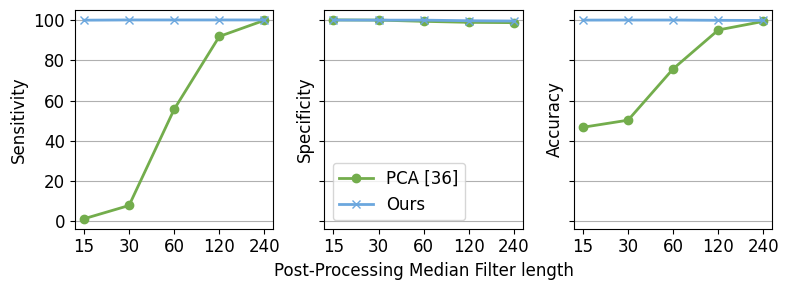

In [12]:
# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(8, 3), sharey = True, sharex=True)
x = np.arange(5)
linewidth= 2
# Plot acc_PCA and acc_enc in the first subplot
axs[0].plot(x, sens_PCA, color=colors[0], marker='o', linewidth=linewidth, label='PCA [36]')
axs[0].plot(x, sens_enc, color=colors[1], marker='x', linewidth=linewidth, label='Ours')
axs[0].set_ylabel('Sensitivity', fontsize=12)
axs[0].set_xlabel('Time Window [#]')
for ax in axs:
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.yaxis.grid(True)
    # ax.xaxis.grid(True)
    ax.tick_params(labelsize=12)

axs[1].plot(x, spec_PCA, color=colors[0], marker='o', linewidth=linewidth, label='PCA [36]')
axs[1].plot(x, spec_enc, color=colors[1], marker='x', linewidth=linewidth, label='Ours')
axs[1].set_ylabel('Specificity', fontsize=12)
axs[1].set_xlabel('Post-Processing Median Filter length', fontsize=12)
axs[1].legend(fontsize=12)
# axs[1].set_xticks(x)
# axs[1].set_xticklabels([15, 30, 60, 120, 240])
# axs[1].set_xlabel('Time Window [#]')

axs[2].plot(x, acc_PCA, color=colors[0], marker='o', linewidth=linewidth, label='PCA [36]')
axs[2].plot(x, acc_enc, color=colors[1], marker='x', linewidth=linewidth, label='Ours')
axs[2].set_ylabel('Accuracy', fontsize=12)
axs[2].set_xticks(x)
axs[2].set_xticklabels([15, 30, 60, 120, 240])
plt.subplots_adjust(hspace=0.1)
# plt.show()
plt.tight_layout()
plt.savefig("Results/images/Anomaly_detection_Bars.pdf", dpi=600)

### 2) Reconstruction plot

/tmp/ipykernel_243300/2359419309.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


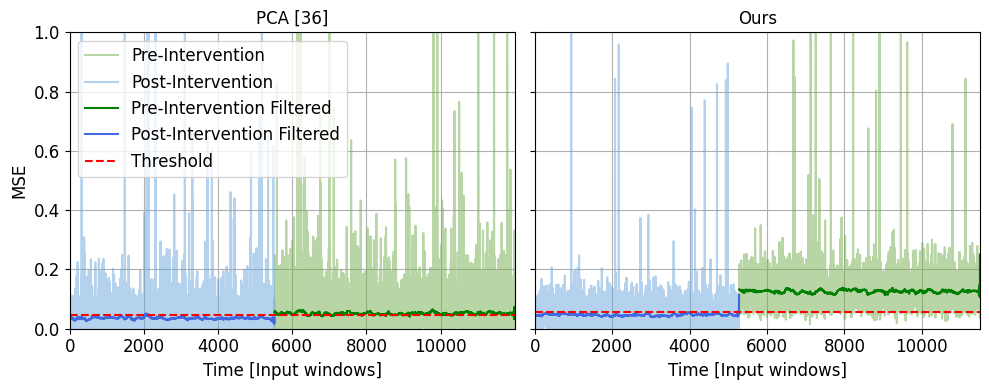

In [6]:
data_normal = pd.read_csv(directory + "PCA_490samples_normal.csv")
data_anomaly = pd.read_csv(directory + "PCA_490samples_anomaly.csv")
fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize = (7,7), sharex=True)
# fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (10,4), sharey=True)
axs[0].tick_params(labelsize=12)
min, max = plot_results_PCA(data_anomaly.values, data_normal.values, axs[0])
compute_threshold_accuracy(data_anomaly.values, data_normal.values, axs[0], min, max)
axs[0].legend(fontsize=12)
data_normal = pd.read_csv(directory + "masked_1190samples_normal_768-512.csv")
data_anomaly = pd.read_csv(directory + "masked_1190samples_anomaly_768-512.csv")
min, max = plot_results_autoencoder(data_anomaly.values, data_normal.values, axs[1])
compute_threshold_accuracy(data_anomaly.values, data_normal.values, axs[1], min, max)
axs[1].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(f"Results/images/Anomaly_detection_MSE.pdf", dpi = 600)
# plt.show()